In [1]:
%matplotlib inline

# 训练分类器

# 数据
通常，需要处理图像、文本、音频或视频数据时，可以使用将数据加载到Numpy数组中的标准Python包。

然后，将该数组转化为`torch.Tensor`。

1. 对于图像: `Pillow`, `OpenCV`
2. 对于音频: `SciPy`, `librosa`
3. 对于文本: `Cython`, `NLTK`, `SpaCy`

针对视觉，有一个名为`torchvision`的包，其中包含用于常见数据集（例如ImageNet、CIFAR10、MNIST等）的数据加载器，以及用于图像（即`torchvision.datasets`和`torch.utils.data.DataLoader`）的数据转换器。

本教程使用CIFAR10数据集。

具有以下类别：飞机、汽车、鸟、猫、鹿、狗、青蛙、马、船、卡车

CIFAR10中的图像尺寸为`3*32*32`。

# 训练图像分类器
执行以下步骤：

1. 使用`torchvision`加载并标准化CIFAR10训练和测试数据集
2. 定义卷积神经网络
3. 定义损失函数
4. 根据训练数据训练网络
5. 在测试数据上测试网络

# 加载并标准化CIFAR10
使用`torchvision`，加载CIFAR10非常容易

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

`torchvision`数据集的输出是`[0,1]`范围的`PILImage`图像。

需要将他们转换为归一化范围`[-1,1]`的张量。

<div class="alert alert-info">
    <h4>注意</h4>
    <p>
        如果在windows上运行并且得到了一个`BrokenPipeError`错误，
        尝试设置`torch.utils.data.DataLoader()`的`num_worker`为0
    </p>
</div>

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100.0%


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


展示一些训练数据

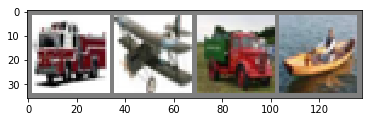

truck plane truck  ship


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

# 定义卷积神经网络
之前从“神经网络”部分复制神经网络，然后对其进行修改以获取3通道图像（而不是定义的1通道图像）

In [6]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

# 定义损失函数和优化器
使用分类交叉熵损失和带有动量的SGD

In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# 训练网络
遍历数据迭代器，将输入馈送入网络并进行优化

In [8]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.209
[1,  4000] loss: 1.905
[1,  6000] loss: 1.704
[1,  8000] loss: 1.595
[1, 10000] loss: 1.556
[1, 12000] loss: 1.497
[2,  2000] loss: 1.434
[2,  4000] loss: 1.393
[2,  6000] loss: 1.377
[2,  8000] loss: 1.352
[2, 10000] loss: 1.318
[2, 12000] loss: 1.281
Finished Training


保存训练完的模型

In [9]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

# 根据测试数据测试网络
在训练数据集中对网络进行了2次训练，但是需要检查网络是否学到了什么。

将通过预测神经网络输出的类别标签并根据实际情况进行检查。

如果预测正确，则将样本添加到正确预测列表中。

第一步，显示测试集中的图像以使其熟悉。

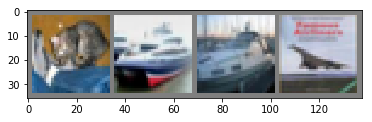

GroundTruth:    cat  ship  ship plane


In [10]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

接下来，重新加载保存的模型

In [11]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

现在看看神经网络对以上示例的看法

In [12]:
outputs = net(images)

输出的是10类的概率，一个类别的概率越高，网络就认为该图像属于该类别。

In [13]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship  ship


结果似乎还不错。

接下去看一下网络在整个数据集上的表现

In [14]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network 
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 55 %


看起来比偶然更好，准确率是55%。

In [15]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data    
        outputs = net(images)    
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

  
# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname, 
                                                   accuracy))

Accuracy for class plane is: 59.0 %
Accuracy for class car   is: 65.7 %
Accuracy for class bird  is: 38.0 %
Accuracy for class cat   is: 40.4 %
Accuracy for class deer  is: 45.7 %
Accuracy for class dog   is: 28.3 %
Accuracy for class frog  is: 79.3 %
Accuracy for class horse is: 58.8 %
Accuracy for class ship  is: 70.0 %
Accuracy for class truck is: 65.9 %


# 在GPU上进行训练
将张量转移到GPU上一样，需要将神经网络转移到GPU上。

如果可以使用CUDA，首先将我们的设备定义为第一个可见的cuda设备

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cpu


然后，这些方法将递归遍历所有模块，并将其参数和缓冲器转换为CUDA张量

In [17]:
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

注意，必须要将每一步的输入和目标也发送到GPU

In [18]:
inputs, labels = data[0].to(device), data[1].to(device)